In [5]:
import numpy as np
import seaborn as sns
import categorization_basic_sims as cat
import scipy.spatial.distance as dist
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from scipy.cluster.hierarchy import dendrogram
import sklearn.metrics as metrics
import pandas as pd
from itertools import combinations

In [6]:
# Create labels
superLabels = np.concatenate([np.repeat(i, 400) for i in range(2)])
basicLabels = np.concatenate([np.repeat(i, 200) for i in range(4)])
subLabels = np.concatenate([np.repeat(i, 100) for i in range(8)])

# Concatenate labels into columns
hierLabels = np.concatenate([superLabels, basicLabels, subLabels]).reshape(3, -1).T

In [12]:
# Load csv
imgInfo = pd.read_csv("./deepCatsTrainImages.csv")

# Sort the rows by super, basic, then sub (regardless of set)
imgInfo = imgInfo.sort_values(by=["super", "basic", "sub"])
imgInfo = imgInfo.reset_index(drop=True)

KeyError: 'super'

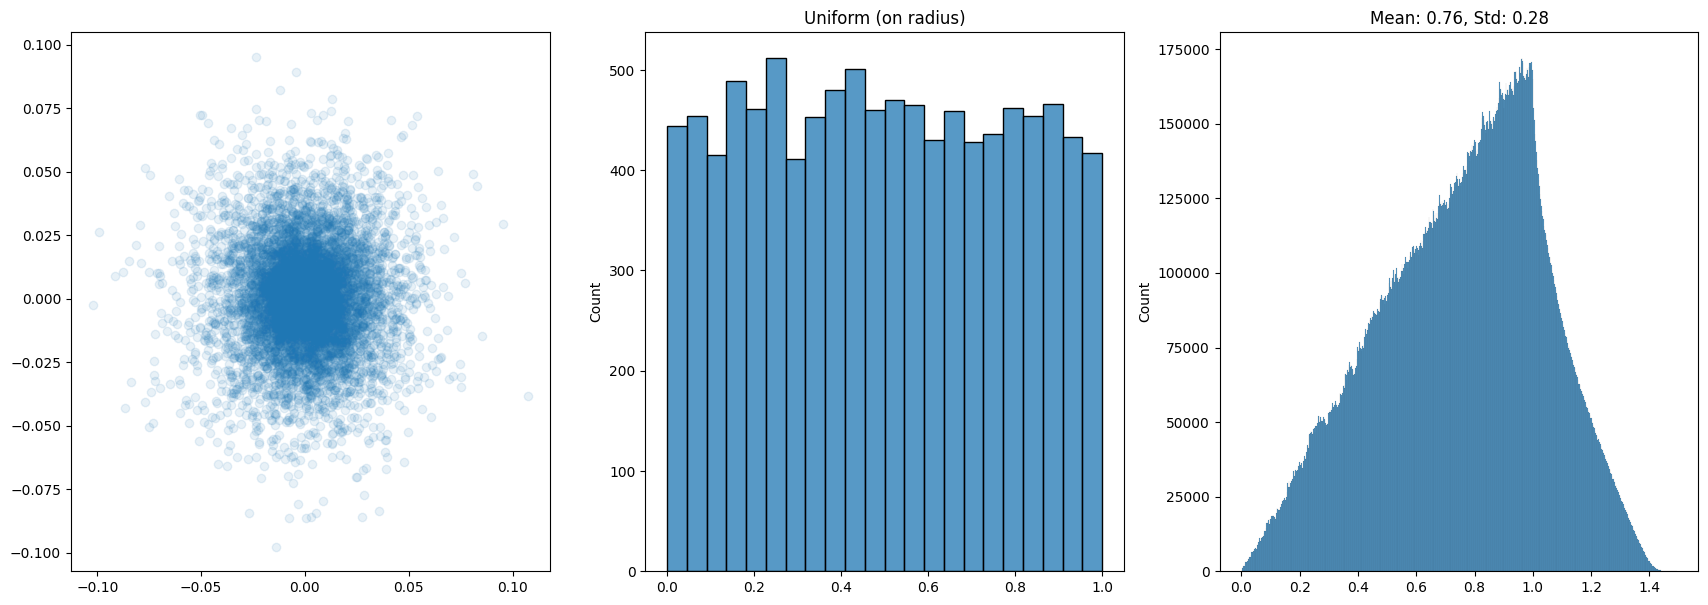

In [9]:
# Generate exemplars
nExemplars = 10_000
center = np.zeros((1000,))
radius = 1
relu = False

uniformExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="uniform", relu=relu
)

uniformSims = dist.pdist(uniformExemplars, metric="euclidean")

# Plot uniform distribution in 1x3 layout
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

axs[0].scatter(uniformExemplars[:, 0], uniformExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(uniformExemplars, axis=1), ax=axs[1])
_ = sns.histplot(uniformSims, ax=axs[2])
_ = axs[1].set_title("Uniform (on radius)")
_ = axs[2].set_title(
    f"Mean: {np.mean(uniformSims):.2f}, Std: {np.std(uniformSims):.2f}"
)

# Simulate full categories with subordinates

In [10]:
# Create simulated categories with category separation all the way down
subExemplars, subCentroids, subLabels = cat.make_categories( #added subLabels
    cat_rad=1,
    super_rad=1,
    basic_rad=0.5,
    sub_rad=0.25,
    nFeatures=2, #Changed to 2
    nImages=100,
    relu=True,
    radius_density="uniform", #changed power to uniform
)

In [11]:
# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
from categorization_basic_sims import diana

subClusters = diana(subExemplars, "euclidean", max_clusters=None)
subLinkage = subClusters.linkage_matrix()

# Calculate dissimilarity matrix
subDistMat = dist.squareform(dist.pdist(subExemplars, metric="euclidean"))
subSimMat = 1 / (1 + subDistMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subMDS = tmp.fit_transform(subDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subTSNE = tmp.fit_transform(subDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

/Users/tobasum/deepCats/categorization_basic_sims.py:611: RuntimeWarning: invalid value encountered in divide
  return np.sum(simMatrix, axis=0) / (simMatrix.shape[0] - 1)


ValueError: zero-size array to reduction operation maximum which has no identity

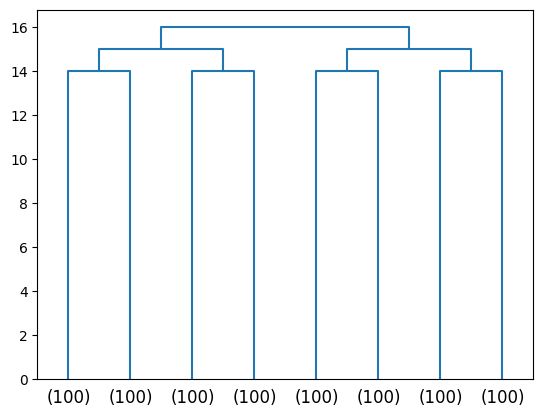

In [ ]:
_ = dendrogram(subLinkage, labels=subLabels, truncate_mode="leveal", p=2)

In [ ]:
cat.print_cluster_stats(subClusters.tree, hierLabels, subExemplars)

AttributeError: module 'categorization_basic_sims' has no attribute 'print_cluster_stats'